In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from datetime import timedelta
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np
import sklearn
theme = 'seismic'
from sklearn.datasets import make_blobs
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [70]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [71]:
# to figure out whether there are any missing values needed to impute or clean - there is not any
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [72]:
df.describe()

,Transaction ID,Customer ID,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,461.410984,677.040726
std,2886.89568,1152.371939,399.984400,334.582413,432.386769
min,1.00000,1000.000000,1.000000,0.000000,1.000000
25%,2500.75000,2001.750000,262.969956,181.109688,295.523894
50%,5000.50000,3004.000000,522.370941,404.367010,653.143168
75%,7500.25000,4010.000000,788.415931,676.079655,1048.479972
max,10000.00000,4999.000000,2953.394492,1500.000000,1694.715674


In [73]:
# create binary output for the fraud
df['binary_output'] = df['Fraud'].apply(lambda x: 1 if x=='Yes' else 0)
df['binary_output'].value_counts()

binary_output
0    8608
1    1392
Name: count, dtype: int64

In [74]:
# what is the % of frauds
df['binary_output'].value_counts(normalize=True) * 100

binary_output
0    86.08
1    13.92
Name: proportion, dtype: float64

## EDA

a. Conduct exploratory analysis on the provided dataset. State your hypothesis based on the insights from your exploration. [2 marks]

Since there are so few frauds in this dataset, it is unlikely that a predictive model will perform well due to the limited data

Fraud (Original Features):
Transaction Amount             0.360897
Customer ID                   -0.009120
Transaction ID                -0.011482
Previous Transaction Amount   -0.236843
Time Since Last Transaction   -0.268011
Name: binary_output, dtype: float64


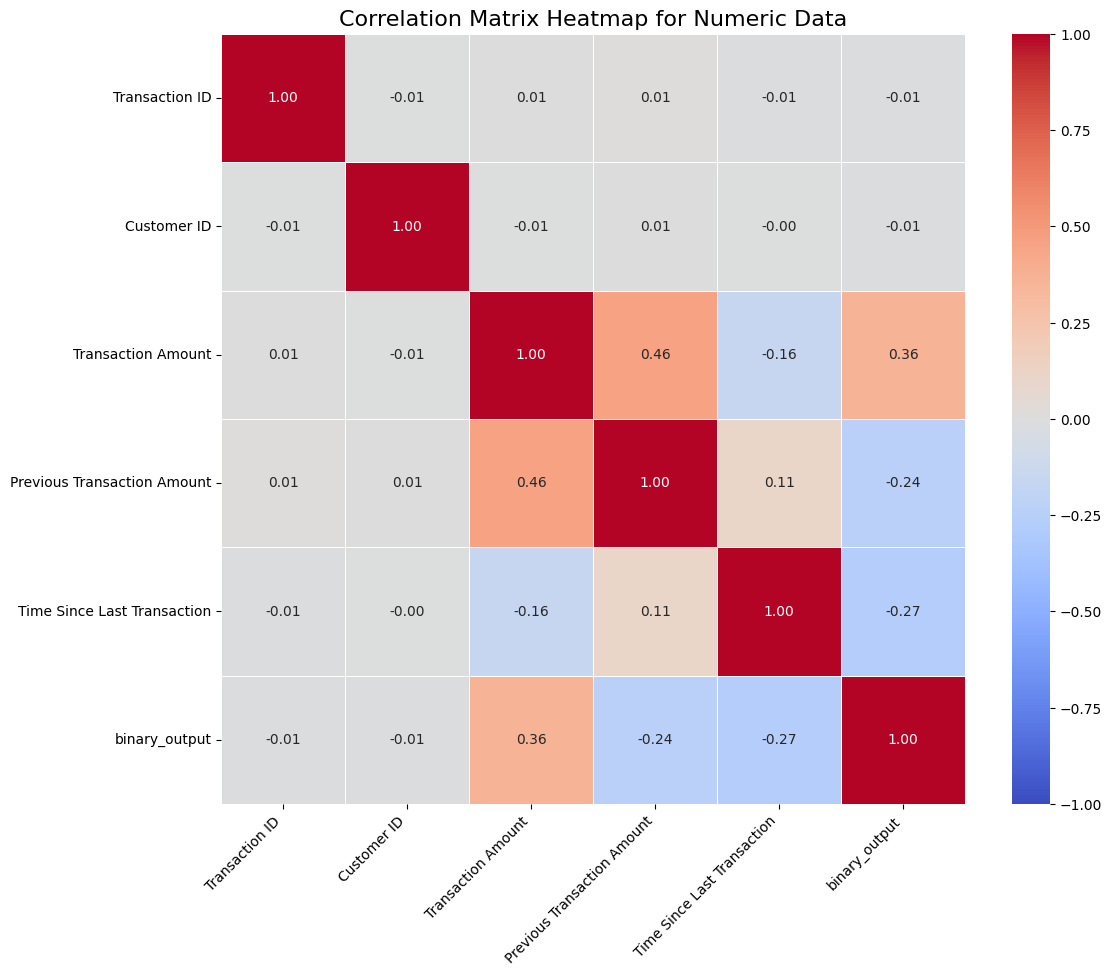

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1311/2565507243.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_corr.values, y=fraud_corr.index, palette='viridis')


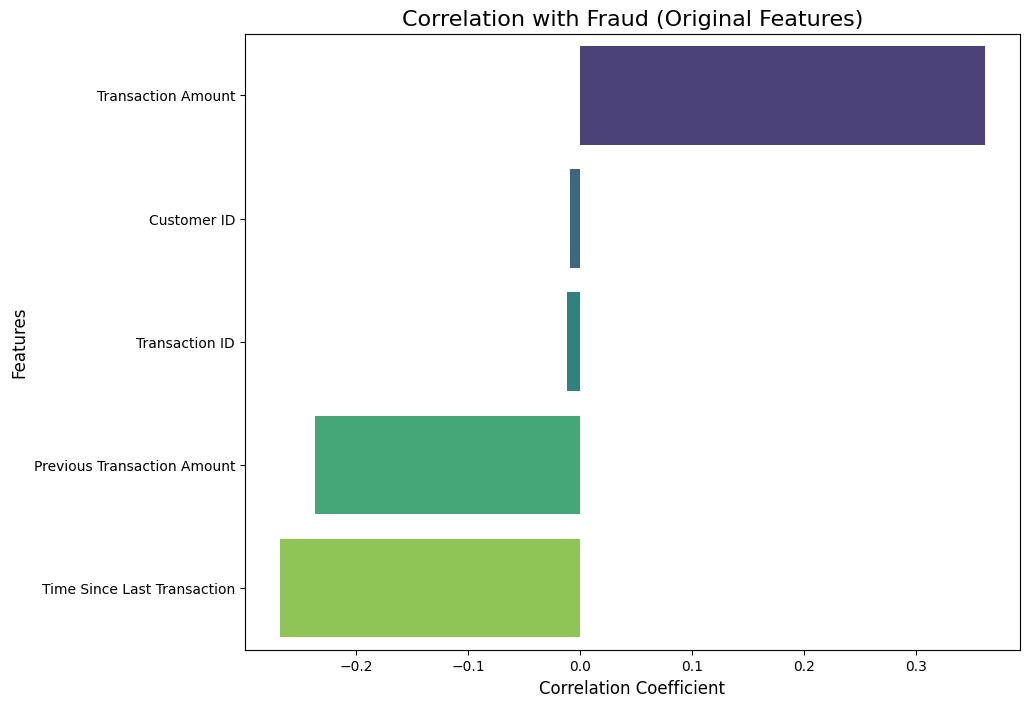

In [75]:
# Correlation Analysis
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
fraud_matrix = df[numerical_features].corr()

# Correlation with the target variable
fraud_corr = fraud_matrix['binary_output'].drop('binary_output').sort_values(ascending=False)
print("Fraud (Original Features):")
print(fraud_corr)

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(fraud_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap for Numeric Data', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Bar plot for correlation with attrition
plt.figure(figsize=(10, 8))
sns.barplot(x=fraud_corr.values, y=fraud_corr.index, palette='viridis')
plt.title('Correlation with Fraud (Original Features)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

<Axes: xlabel='Transaction Amount', ylabel='Fraud'>

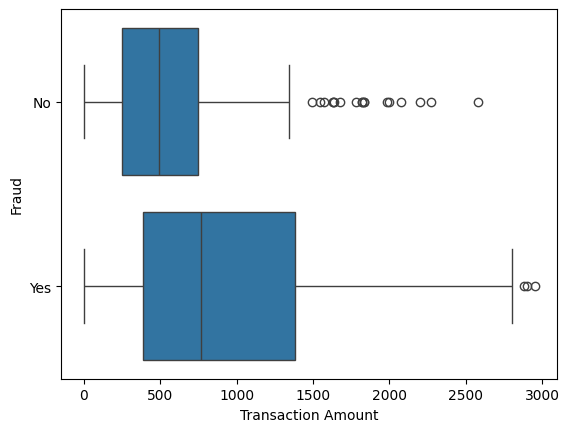

In [76]:
sns.boxplot(x='Transaction Amount', y='Fraud', data=df)

In [77]:
transaction_fraud = df.groupby('binary_output')['Transaction Amount'].mean()
transaction_fraud
# if the avg transaction amount for frauds is $918, which is $400+ more than non-frauds, the dataset could be split in this way to make it more balanced since the raw data has only 14% of it comprising frauds

binary_output
0    501.819538
1    918.817167
Name: Transaction Amount, dtype: float64

In [78]:
recency_fraud = df.groupby('binary_output')['Time Since Last Transaction'].mean()
recency_fraud
# if the time since last transaction for frauds is 388 days, which is 300+ fewer days than non-frauds, the dataset could be split in this way to make it more balanced since the raw data has only 14% of it comprising frauds

binary_output
0    723.639166
1    388.880259
Name: Time Since Last Transaction, dtype: float64

In [79]:
df['victimized'] = df.groupby('Customer ID')['binary_output'].sum()
df['victimized'].value_counts()

# potentially could have made separate dataframe that grouped by customer id to hone in on people who were victimized multiple times but in this case there were so few repeat cases this was not considered

victimized
0.0    2490
1.0     982
2.0     168
3.0      22
4.0       2
Name: count, dtype: int64

Hypothesis: The model will be unable to strongly detect fraud due to the limited amount of frauds in relation to non-fraudulent transactions.

## DATA PREP - FEATURE ENGINEERING AND TRANSFORMATIONS

b. Prepare your data for modelling (i.e., data transformations and feature engineering). [3 MARKS]

In [80]:
df['Merchant Category'].value_counts()

Merchant Category
Dining         2077
Clothing       2052
Groceries      1983
Electronics    1955
Travel         1933
Name: count, dtype: int64

In [81]:
def Merchant_Categorical(x):
    if x == 'Dining':
        return 1
    elif x == 'Groceries':
        return 2
    elif x == 'Electronics':
        return 3
    elif x == 'Clothing':
        return 4
    elif x == 'Travel':
        return 5
    else:
        return 0

In [82]:
df['Merchant_Categorical'] = df['Merchant Category'].apply(Merchant_Categorical)


In [83]:
df['Device Type'].value_counts()

Device Type
desktop    5081
mobile     4919
Name: count, dtype: int64

In [84]:
def Device_Categorical(x):
    if x == 'mobile':
        return 1
    elif x == 'desktop':
        return 2
    else:
        return 0

In [85]:
df['Device_Categorical'] = df['Device Type'].apply(Device_Categorical)

In [86]:
df['Location'].value_counts()

Location
Houston          2373
Los Angeles      1956
Chicago          1915
San Francisco    1890
New York         1866
Name: count, dtype: int64

In [87]:
def Location_Categorical(x):
    if x == 'Houston':
        return 1
    elif x == 'Los Angeles':
        return 2
    elif x == 'Chicago':
        return 3
    elif x == 'New York':
        return 4
    elif x == 'San Francisco':
        return 5
    else:
        return 0

In [88]:
df['Location_Categorical'] = df['Location'].apply(Location_Categorical)

In [89]:
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

In [90]:
# isolate the hour of the day
df['hour'] = df['Transaction Date and Time'].apply(lambda x: x.hour)

In [91]:
# time of day
def purchase_time_of_day(x):
    if x >=6 and x<=9:
        return 'morning_buy'
    elif x > 9 and x <=15:
        return 'midday_purchase'
    elif x > 15 and x<=19:
        return 'evening_purchase'
    else:
        return 'afterhours_purchase'

In [92]:
df['purchase_time_of_day'] = df['hour'].apply(purchase_time_of_day)
df['purchase_time_of_day'].value_counts()

purchase_time_of_day
afterhours_purchase    4120
midday_purchase        2520
morning_buy            1680
evening_purchase       1680
Name: count, dtype: int64

In [93]:
def Purchase_Time_Categorical(x):
    if x == 'afterhours_purchase':
        return 1
    elif x == 'Los midday_purchase':
        return 2
    elif x == 'evening_purchase':
        return 3
    elif x == 'morning_buy':
        return 4
    else:
        return 0

In [94]:
df['Purchase_Time_Categorical'] = df['purchase_time_of_day'].apply(Purchase_Time_Categorical)

In [95]:
# isolate day to weekdays or not
# note panda records 0 as Monday and 6 as Sunday
df['weekday'] = df['Transaction Date and Time'].apply(lambda x: x.weekday())

In [96]:
# Tier the transaction amount
df['Transaction_Tier'] = pd.qcut(df['Transaction Amount'], 3, labels=[1, 2, 3])

In [97]:
# creating separate dataframe using the two strongest coefficients avgs for fraud to segment data as an attempt to re-balance
fraud_df = df[(df['Transaction Amount'] >= 502) & (df['Time Since Last Transaction'] < 723)]
fraud_df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,binary_output,victimized,Merchant_Categorical,Device_Categorical,Location_Categorical,hour,purchase_time_of_day,Purchase_Time_Categorical,weekday,Transaction_Tier
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,0,NaN,4,2,2,0,afterhours_purchase,1,6,2
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,0,NaN,3,1,2,0,afterhours_purchase,1,6,3
6,7,4772,967.649233,2023-01-01 00:06:00,Groceries,Los Angeles,1226.767073,331.319088,desktop,No,0,NaN,2,2,2,0,afterhours_purchase,1,6,3
9,10,3169,909.749227,2023-01-01 00:09:00,Electronics,Chicago,571.664421,505.032036,mobile,No,0,NaN,3,1,3,0,afterhours_purchase,1,6,3
11,12,2238,568.220861,2023-01-01 00:11:00,Clothing,Houston,553.575100,420.081384,desktop,No,0,NaN,4,2,1,0,afterhours_purchase,1,6,2


In [98]:
fraud_df['binary_output'].value_counts()

binary_output
0    2132
1     801
Name: count, dtype: int64

In [99]:
fraud_df['binary_output'].value_counts(normalize=True) * 100
# because this improved the imbalancing by quite a bit, this data frame will be used as the feature engineering is commenced

binary_output
0    72.690078
1    27.309922
Name: proportion, dtype: float64

In [100]:
# Tier the transaction amount
fraud_df['Transaction_Tier'] = pd.qcut(fraud_df['Transaction Amount'], 3, labels=[1, 2, 3])

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1311/3071457737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud_df['Transaction_Tier'] = pd.qcut(fraud_df['Transaction Amount'], 3, labels=[1, 2, 3])


Re-evaluation of Coefficients post-Feature Engineering

Fraud (Post-Feature Engineering):
Transaction Amount             0.593118
hour                           0.010738
Purchase_Time_Categorical      0.009234
Device_Categorical            -0.008620
Merchant_Categorical          -0.010625
Customer ID                   -0.014275
weekday                       -0.015109
Transaction ID                -0.022349
victimized                    -0.058861
Time Since Last Transaction   -0.273560
Location_Categorical          -0.274011
Previous Transaction Amount   -0.626216
Name: binary_output, dtype: float64


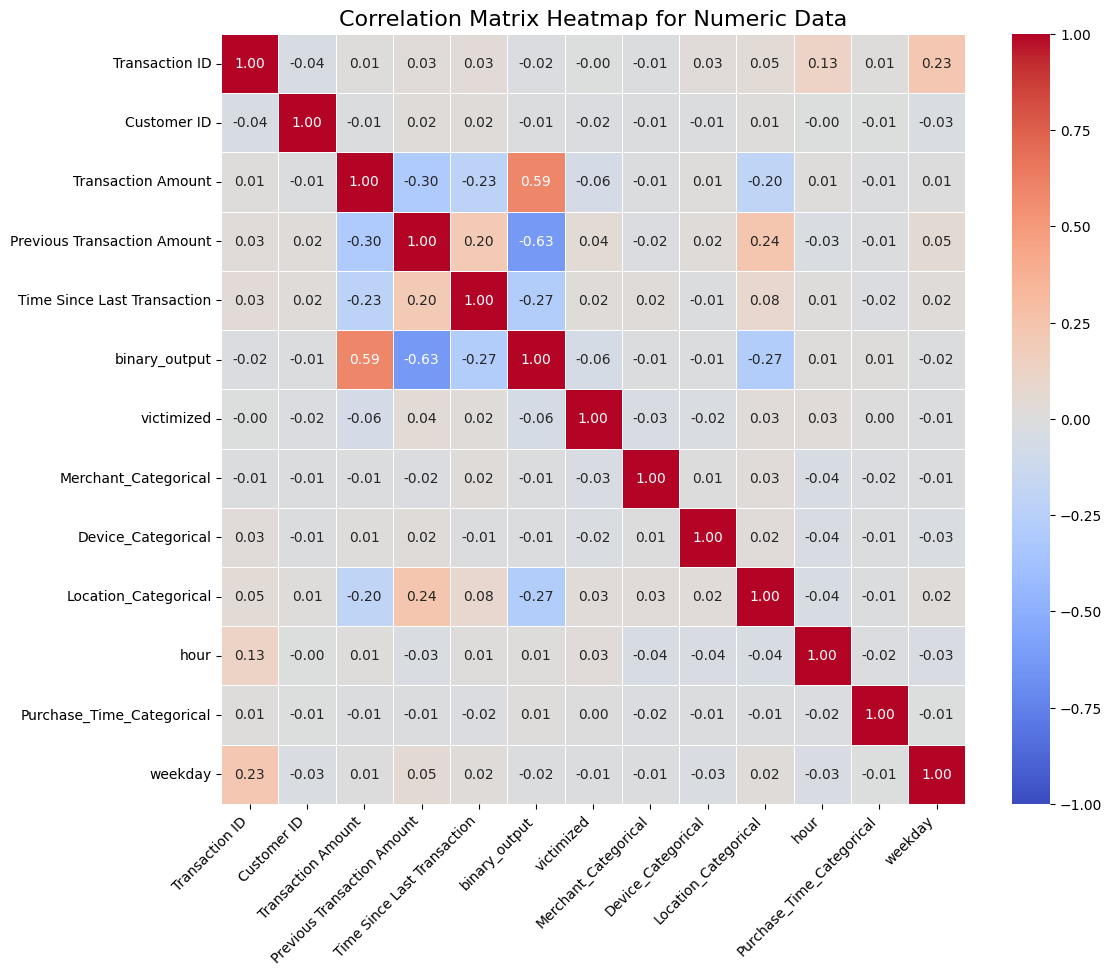

/var/folders/vc/2zbhjcyn0_9gnlqw17sb6wpw0000gn/T/ipykernel_1311/2619151774.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_corr2.values, y=fraud_corr2.index, palette='viridis')


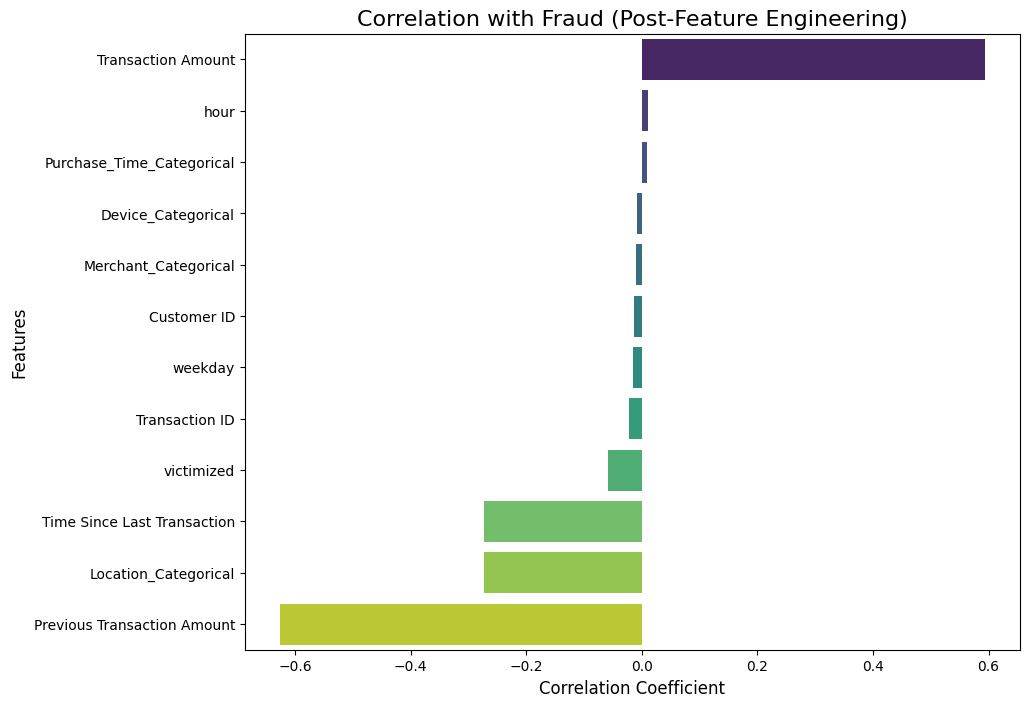

In [101]:
# Correlation Analysis
numerical_features_fraud = fraud_df.select_dtypes(include=['int64', 'float64']).columns
fraud_matrix2 = fraud_df[numerical_features_fraud].corr()

# Correlation with the target variable
fraud_corr2 = fraud_matrix2['binary_output'].drop('binary_output').sort_values(ascending=False)
print("Fraud (Post-Feature Engineering):")
print(fraud_corr2)

# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(fraud_matrix2, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap for Numeric Data', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

# Bar plot for correlation with attrition
plt.figure(figsize=(10, 8))
sns.barplot(x=fraud_corr2.values, y=fraud_corr2.index, palette='viridis')
plt.title('Correlation with Fraud (Post-Feature Engineering)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

## MODEL BUILDING AND EVALUATION

c. Build a model to predict the output variable. Hint: you will need to try several models to find the best model for your problem. [5 marks]

d. Evaluate each model using the evaluation techniques you have learned in class. [3 marks]

In [102]:
fraud_df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,binary_output,victimized,Merchant_Categorical,Device_Categorical,Location_Categorical,hour,purchase_time_of_day,Purchase_Time_Categorical,weekday,Transaction_Tier
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,0,NaN,4,2,2,0,afterhours_purchase,1,6,1
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,0,NaN,3,1,2,0,afterhours_purchase,1,6,2
6,7,4772,967.649233,2023-01-01 00:06:00,Groceries,Los Angeles,1226.767073,331.319088,desktop,No,0,NaN,2,2,2,0,afterhours_purchase,1,6,3
9,10,3169,909.749227,2023-01-01 00:09:00,Electronics,Chicago,571.664421,505.032036,mobile,No,0,NaN,3,1,3,0,afterhours_purchase,1,6,3
11,12,2238,568.220861,2023-01-01 00:11:00,Clothing,Houston,553.575100,420.081384,desktop,No,0,NaN,4,2,1,0,afterhours_purchase,1,6,1


In [103]:
fraud_df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud', 'binary_output', 'victimized',
       'Merchant_Categorical', 'Device_Categorical', 'Location_Categorical',
       'hour', 'purchase_time_of_day', 'Purchase_Time_Categorical', 'weekday',
       'Transaction_Tier'],
      dtype='object')

Feature Selection

In [104]:
X = fraud_df[['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction',
                  'Merchant_Categorical','Device_Categorical', 'Location_Categorical',
                  'Purchase_Time_Categorical', 'weekday']]
y = fraud_df['binary_output']

In [105]:
# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [106]:
# build our pipeline that includes these transformations
numeric_columns = ['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction']
categorical_columns = ['Merchant_Categorical','Device_Categorical', 'Location_Categorical',
                  'Purchase_Time_Categorical', 'weekday']

KNN, LOGREG, NB

In [107]:
# test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()

In [108]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [109]:
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
print(f"knn_scores: {np.mean(knn_scores)}")
print(f"logreg_scores: {np.mean(logreg_scores)}")
print(f"nb_scores: {np.mean(nb_scores)}")

# the scores are largely close but both knn and logreg will be put through the pipeline to be optimized; the best one of the 2 is likely to be selected

knn_scores: 0.907177947699785
logreg_scores: 0.900702079458414
nb_scores: 0.8808284205537996


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Random Forest

In [110]:
# Create a RandomForestRegressor object
model_RFR = RandomForestRegressor(n_estimators=100, random_state=42)

# Splitting the data into training and testing sets
X_train_RFR, X_test_RFR, y_train_RFR, y_test_RFR = train_test_split(X, y, test_size=0.3, random_state=42)

In [111]:
# Fit the model to the training data
model_RFR.fit(X_train_RFR, y_train_RFR)

RandomForestRegressor(random_state=42)

In [112]:
y_pred_RFR = model_RFR.predict(X_test_RFR)
y_pred_RFR

array([0.  , 0.01, 0.01, 0.08, 0.  , 0.05, 0.02, 0.01, 0.88, 0.  , 0.  ,
       0.06, 0.05, 0.  , 0.07, 0.05, 0.03, 0.01, 0.73, 0.13, 0.14, 0.04,
       0.87, 0.02, 0.01, 0.07, 0.05, 0.01, 0.  , 0.  , 0.  , 0.06, 0.08,
       0.96, 0.07, 0.09, 0.04, 0.01, 0.39, 0.02, 0.89, 0.01, 1.  , 0.02,
       0.02, 0.02, 0.15, 0.04, 0.  , 0.08, 0.12, 0.11, 0.08, 0.01, 0.  ,
       0.98, 0.91, 0.89, 0.09, 0.04, 0.03, 0.1 , 0.01, 0.02, 0.78, 0.09,
       0.9 , 0.02, 0.98, 0.05, 0.19, 0.87, 0.01, 1.  , 0.96, 0.09, 0.  ,
       0.  , 0.03, 0.04, 0.99, 0.02, 0.04, 0.02, 0.71, 0.25, 0.84, 0.01,
       0.09, 0.  , 0.08, 0.01, 0.02, 0.06, 0.06, 0.01, 0.12, 0.02, 0.  ,
       0.  , 1.  , 0.03, 0.  , 0.01, 0.9 , 0.01, 0.79, 0.92, 0.88, 0.03,
       0.01, 0.91, 0.02, 1.  , 0.01, 0.04, 0.01, 0.99, 0.01, 0.08, 0.98,
       0.11, 0.05, 0.01, 0.86, 0.01, 0.94, 0.04, 0.02, 1.  , 0.14, 0.07,
       0.  , 0.04, 0.03, 0.84, 0.06, 0.07, 0.28, 0.09, 0.03, 0.02, 0.01,
       1.  , 0.05, 0.01, 0.41, 0.05, 0.01, 0.12, 0.

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       635
           1       0.97      0.87      0.91       245

    accuracy                           0.95       880
   macro avg       0.96      0.93      0.94       880
weighted avg       0.96      0.95      0.95       880



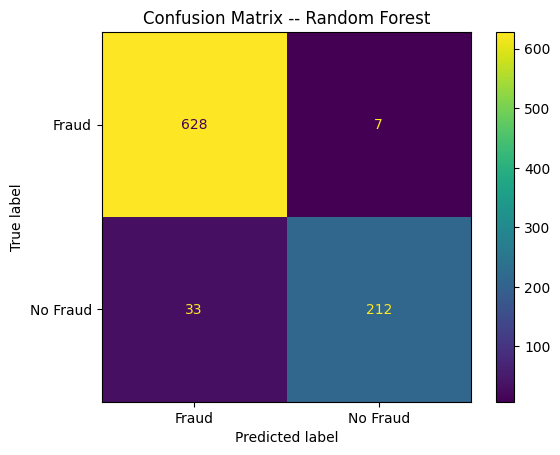

In [113]:
# Convert predictions to binary by applying a threshold
threshold_RFR = 0.5
y_pred_binary_RFR = (y_pred_RFR > threshold_RFR).astype(int)


#  RandomForestRegressor Scores
print(classification_report(y_test_RFR, y_pred_binary_RFR))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test_RFR, y_pred_binary_RFR, display_labels=['Fraud', 'No Fraud'])
plt.title('Confusion Matrix -- Random Forest')
plt.show()

KNN

In [114]:
# reserve 30% for testing
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X,y, test_size=0.3, random_state=42)

In [115]:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [116]:
# build our pipeline
pipeline_KNN = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor_knn),
                        ('classifier',KNeighborsClassifier())
                    ])

In [117]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_knn = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}

In [118]:
# let's perform gridsearch
grid_search_knn = GridSearchCV(pipeline_KNN, param_grid_knn, cv=5, verbose=1, scoring='f1')
grid_search_knn.fit(X_train_knn,y_train_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Transaction '
                                                                          'Amount',
                                                                          'Previous '
                                                                          'Transaction '
                                                                          'Amount',
                                                                          'Time '
                                                                          'Since '
                                                                          'Last '
                                                                          'Transaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Merchant_Categorical',
                                                                          'Device_Categorical',
                                                                          'Location_Categorical',
                                                                          'Purchase_Time_Categorical',
                                                                          'weekday'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [119]:
final_classifier_KNN = KNeighborsClassifier(n_neighbors=grid_search_knn.best_params_['classifier__n_neighbors'],
                                        metric = grid_search_knn.best_params_['classifier__metric'],
                                        weights = grid_search_knn.best_params_['classifier__weights']
                                        )

In [120]:
final_pipeline_KNN = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_knn),
                              ('classifier',final_classifier_KNN)
                          ])

In [121]:
final_pipeline_KNN.fit(X_train_knn,y_train_knn)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Transaction Amount',
                                                   'Previous Transaction '
                                                   'Amount',
                                                   'Time Since Last '
                                                   'Transaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Merchant_Categorical',
                                                   'Device_Categorical',
                                                   'Location_Categorical',
                                                   'Purchase_Time_Categorical',
                                                   'weekday'])])),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7))])

In [122]:
pred_knn = final_pipeline_KNN.predict(X_test_knn)
probs_knn = final_pipeline_KNN.predict_proba(X_test_knn)

In [123]:
# Generate classification report
knn_report = classification_report(y_test_knn, pred_knn)
print(knn_report)

# this one is discarded due to a very poor recall score for the fraud output

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       635
           1       0.83      0.56      0.67       245

    accuracy                           0.85       880
   macro avg       0.84      0.76      0.78       880
weighted avg       0.84      0.85      0.83       880



Logreg

In [124]:
# reserve 30% for testing
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X,y, test_size=0.3, random_state=42)

In [125]:
# build our pipeline
pipeline_LR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [126]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_LR = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]
}

In [127]:
grid_search_LR = GridSearchCV(pipeline_LR, param_grid_LR, cv=5, verbose=1, scoring='f1')
grid_search_LR.fit(X_train_LR,y_train_LR)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
975 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='rais

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Transaction '
                                                                          'Amount',
                                                                          'Previous '
                                                                          'Transaction '
                                                                          'Amount',
                                                                          'Time '
                                                                          'Since '
                                                                          'Last '
                                                                          'Transaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Merchant_Categorical',
                                                                          'Device_Categorical',
                                                                          'Location_Categorical',
                                                                          'Purchase_Time_Categorical',
                                                                          'weekday'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [128]:
final_classifier_LR = LogisticRegression(
    C=grid_search_LR.best_params_['classifier__C'],
    solver=grid_search_LR.best_params_['classifier__solver'],
    penalty=grid_search_LR.best_params_['classifier__penalty'],
    max_iter=grid_search_LR.best_params_['classifier__max_iter']
)

In [129]:
final_pipeline_LR = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor),
                              ('classifier',final_classifier_LR)
                          ])

In [130]:
final_pipeline_LR.fit(X_train_LR, y_train_LR)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Transaction Amount',
                                                   'Previous Transaction '
                                                   'Amount',
                                                   'Time Since Last '
                                                   'Transaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Merchant_Categorical',
                                                   'Device_Categorical',
                                                   'Location_Categorical',
                                                   'Purchase_Time_Categorical',
                                                   'weekday'])])),
                ('classifier',
                 LogisticRegression(C=1, penalty='l1', solver='saga'))])

In [131]:
pred_LR = final_pipeline_LR.predict(X_test_LR)
probs_LR = final_pipeline_LR.predict_proba(X_test_LR)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       635
           1       0.97      0.84      0.90       245

    accuracy                           0.95       880
   macro avg       0.96      0.92      0.93       880
weighted avg       0.95      0.95      0.95       880



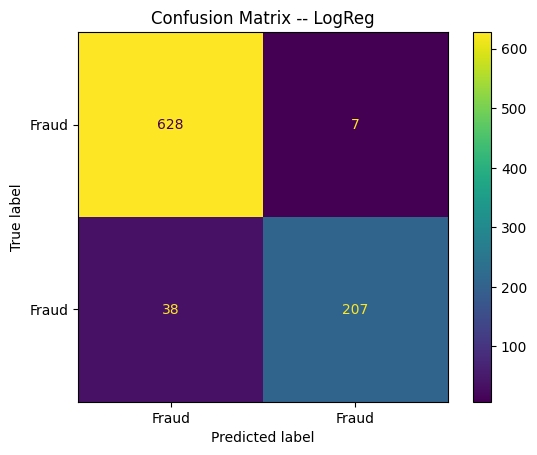

In [132]:
report_LR = classification_report(y_test_LR, pred_LR)
print(report_LR)

# Confusion Matrix for LogReg
ConfusionMatrixDisplay.from_predictions(y_test_LR, pred_LR, display_labels=['Fraud', 'Fraud'])
plt.title('Confusion Matrix -- LogReg')
plt.show()

# potential candidate to be final model; not much discrepancy between scores and the fraud scores are strong; however, have a 0.99 recall is a little alarming for the non-fraud output

SVM

In [133]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X,y, test_size=0.3, random_state=42)

In [134]:
# test SVM
svm = Pipeline(steps = [('preprocessor', preprocessor), ('svm', SVC(random_state=1))])

# fit
svm.fit(X_train_svm, y_train_svm)

# predict
pred_svm = svm.predict(X_test_svm)

# Generate classification report for SVM
report_svm = classification_report(y_test_svm, pred_svm)
print(report_svm)

# easily discarded due to the lower recall score and high discrepancy between precision and recall for fraud output

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       635
           1       0.95      0.78      0.86       245

    accuracy                           0.93       880
   macro avg       0.94      0.88      0.91       880
weighted avg       0.93      0.93      0.93       880



## MODEL SELECTION


e. Select and optimize your final model. [2 marks] - note: that the models were all optimized prior and this is just the final model that was selected

Final model selected was Random Forest Regressor because it had the highest scores for the '1' output which was put in as a placeholder for fraud; the priority was to have a higher recall score to capture as many fraudulent transactions as possible

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       635
           1       0.97      0.87      0.91       245

    accuracy                           0.95       880
   macro avg       0.96      0.93      0.94       880
weighted avg       0.96      0.95      0.95       880



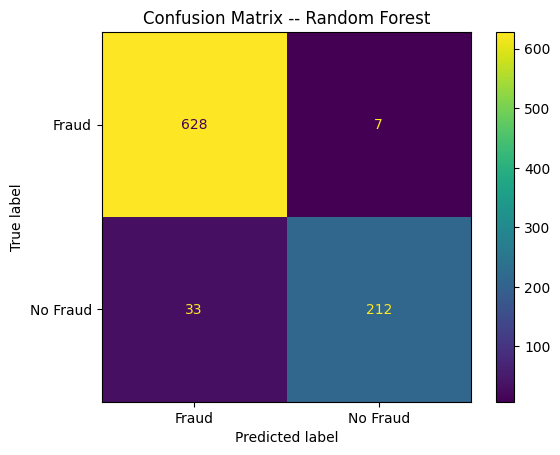

In [135]:
# Convert predictions to binary by applying a threshold
threshold_RFR = 0.5
y_pred_binary_RFR = (y_pred_RFR > threshold_RFR).astype(int)


#  RandomForestRegressor Scores
print(classification_report(y_test_RFR, y_pred_binary_RFR))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test_RFR, y_pred_binary_RFR, display_labels=['Fraud', 'No Fraud'])
plt.title('Confusion Matrix -- Random Forest')
plt.show()

# potential for model to be a little overfitted with 0.99 recall but nevertheless, it is for the non-fraud output so less concerning since the objective is to predict fraudulent transactions; a more in-depth explanation is found below

# CONCLUSION AND BUSINESS EXPLANATIONS

f. Explain your model to a business executive. Your explanation should include the following: [5 marks]

i. Your data exploration findings, initial hypothesis, and whether the hypothesis proved true.

ii. Your approach for building and evaluating the model. 

 iii. The final model you selected and how you know this is the best model for the problem.

 iv. How the model should be used by the business, in business process.

In [136]:
fraud_df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,binary_output,victimized,Merchant_Categorical,Device_Categorical,Location_Categorical,hour,purchase_time_of_day,Purchase_Time_Categorical,weekday,Transaction_Tier
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,0,NaN,4,2,2,0,afterhours_purchase,1,6,1
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,0,NaN,3,1,2,0,afterhours_purchase,1,6,2
6,7,4772,967.649233,2023-01-01 00:06:00,Groceries,Los Angeles,1226.767073,331.319088,desktop,No,0,NaN,2,2,2,0,afterhours_purchase,1,6,3
9,10,3169,909.749227,2023-01-01 00:09:00,Electronics,Chicago,571.664421,505.032036,mobile,No,0,NaN,3,1,3,0,afterhours_purchase,1,6,3
11,12,2238,568.220861,2023-01-01 00:11:00,Clothing,Houston,553.575100,420.081384,desktop,No,0,NaN,4,2,1,0,afterhours_purchase,1,6,1



It was surprising to find out that the initial hypothesis was flat out wrong. The initial belief was that there would not be any model strong enough to predict fraud based on the dataset due to how limited the fraud count was (14%). While it did jump up after the dataframe was split using the avg transaction amount and avg time since last transactions for fraud as cut off to make the data more balanced, frauds still only took up just over 30% of the data. However, since the transaction amount coefficient was so strong, it made it so nearly all the models performed relatively well.

Based on the correlation coefficients before and after the feature engineering, nothing came close to matching the strength of transaction amount. This was regardless of the extensive amount of new features made. At one point in time it was even considered to have a new dataframe based on customer profile that would have consolidated the dataframe by customer id and done a count on frauds. However, it proved to be unnecessary because the data itself presented such strong correlation to the fraud output. Once the dataset was separated, the coefficient for transaction amount nearly doubled, significantly strengthening its relationship with fraud. The dataset was prepped to utilize as many features as possible with as much variation to ensure that the inputs were not predicting the outputs. This is why the date tine was broken up into time of day and day of the week. While the columns of location, time, merchant, and device were formatted as categoricals. It was at one point considered to tier the transactions but because the transaction amount had such a high coefficeint, this proved to be immaterial so it was ultimately removed from the features.

When the models were built, it was clear that the output was built to be binary as fraud or not fraud. With this in mind, the priority was to find a model that captured as many fraud transactions as possible. While some models may have a high overall f1-score, each model was built with a classification report to see how it performed in particular with predicting frauds. Unsurprisingly, all of the models performed remarkably well in predicting non fraudulent transactions as this made up the majority of the dataset and this was a dataset of transactions. However, the models' varied in success when it came to predicting the fraudulent transactions.

The initial test had the features ran through the KNN, logreg, and NB models to see  how they would perform generally. It was found that KNN and logreg performed the best so both were optimized and fitted through a pipeline and grid search. Surprisngly, the KNN overall accuracy score was largely inflated from how it performed in predicting non-frauds and performed rather poorly in predicting frauds with an f1-score of just 0.67. Meanwhile, while the logreg performed better than the KNN, its f1-score for fraud was inflated by precision. With an objective to capture as many fraudulent transactions as possible, the goal was to get the recall score as high as possible.

Multiple models could have the same score but the one with the highest recall score would be key as in a business setting catching as many frauds as possible is key. Inaccurately predicting a non-fraud transaction as fraud due to a lower precision is a worthwhile trade-off as opposed to missing a fraudulent transaction due to a lower recall score. 

With this in mind, the random forest regressor and SVM were also tested to see if any could have a higher recall score than the logreg's 0.84 for frauds. The SVM was quickly discarded as it only performed at 0.78. However, the random forest regressor narrowly edged out the logreg with a recall score of 0.87. WHile there are concerns of the data potentially being compromised. As mentioned before, the reason they all performed so well was because of how strong of a relationship transaction amount had with frauds. 

In terms of how the random forest regressor model can be used, it can be utilized to mark transactions over a certain monetary threshold as a fraud risk. With this in mind it can partner with banks to have automated fraud alert messages sent to users whenever they do a transaction over a certain amount as a precaution to notify them of the fraud risk. With the average fraud transaction being around $900 or more, whenever a transaction of this nature is made, an alert will be sent to the user to caution them of the fraud risk using this model. Through doing this, the user is able to be notified of the fraud and the company is able to track the fraud as soon as possible; this is imperative to fulfilling the business objective as the more time elapses following a fraud, the more difficult it will be to find the culprit.


Regular DF Model Test

In [137]:
X_og = df[['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction',
                  'Merchant_Categorical','Device_Categorical', 'Location_Categorical',
                  'Purchase_Time_Categorical', 'weekday']]
y_og = df['binary_output']

In [138]:
# reserve 30% for testing
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_og,y_og, test_size=0.3, random_state=42)

In [139]:
# build our pipeline that includes these transformations
numeric_columns_og = ['Transaction Amount','Previous Transaction Amount', 'Time Since Last Transaction']
categorical_columns_og = ['Merchant_Categorical','Device_Categorical', 'Location_Categorical',
                  'Purchase_Time_Categorical', 'weekday']

KNN, LogReg, NB

In [140]:
# test 3 models with cross validation to see which ones work best for this data
knnOG = KNeighborsClassifier()
logregOG = LogisticRegression()
nbOG = GaussianNB()

In [141]:
preprocessor_og = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_og),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_og)
    ]
)

In [142]:
# cross validation to determine in general which model works best for the given problem
knn_scores_og = cross_val_score(knnOG, X_train_v2, y_train_v2, scoring='f1', cv=5)
logreg_scores_og = cross_val_score(logregOG, X_train_v2, y_train_v2, scoring='f1', cv=5)
nb_scores_og = cross_val_score(nbOG, X_train_v2, y_train_v2, scoring='f1', cv=5)
print(f"knn_scores: {np.mean(knn_scores_og)}")
print(f"logreg_scores: {np.mean(logreg_scores_og)}")
print(f"nb_scores: {np.mean(nb_scores_og)}")

knn_scores: 0.7428371028371028
logreg_scores: 0.6603327474818
nb_scores: 0.5423101350941326


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Random Forest Regressor

In [143]:
# Create a RandomForestRegressor object
model_RFRog = RandomForestRegressor(n_estimators=100, random_state=42)

# Splitting the data into training and testing sets
X_train_RFR2, X_test_RFR2, y_train_RFR2, y_test_RFR2 = train_test_split(X_og, y_og, test_size=0.3, random_state=42)

In [144]:
# Fit the model to the training data
model_RFRog.fit(X_train_RFR2, y_train_RFR2)

RandomForestRegressor(random_state=42)

In [145]:
y_pred_RFR2 = model_RFRog.predict(X_test_RFR2)
y_pred_RFR2

array([0.04, 0.01, 0.08, ..., 0.11, 0.01, 0.05])

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2600
           1       0.91      0.64      0.75       400

    accuracy                           0.94      3000
   macro avg       0.93      0.82      0.86      3000
weighted avg       0.94      0.94      0.94      3000



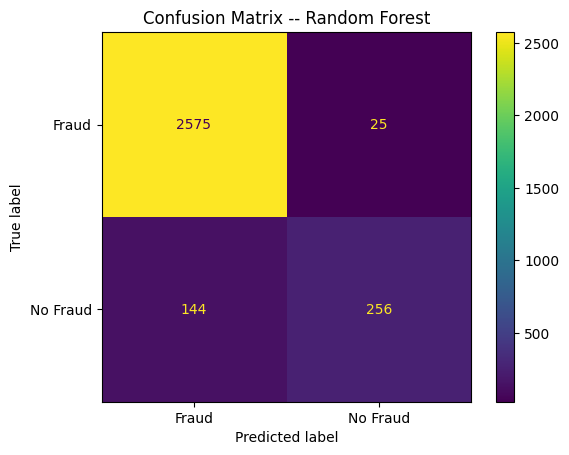

In [169]:
# Convert predictions to binary by applying a threshold
threshold_RFRog = 0.4
y_pred_binary_RFRog = (y_pred_RFR2 > threshold_RFRog).astype(int)


#  RandomForestRegressor Scores
print(classification_report(y_test_RFR2, y_pred_binary_RFRog))

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_predictions(y_test_RFR2, y_pred_binary_RFRog, display_labels=['Fraud', 'No Fraud'])
plt.title('Confusion Matrix -- Random Forest')
plt.show()

KNN

In [147]:
# reserve 30% for testing
X_train_knn2, X_test_knn2, y_train_knn2, y_test_knn2 = train_test_split(X_og,y_og, test_size=0.3, random_state=42)

In [148]:
preprocessor_knn2 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_og),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_og)
    ]
)

In [149]:
# build our pipeline
pipeline_KNN2 = Pipeline(steps=
                    [
                        ('preprocessor',preprocessor_knn2),
                        ('classifier',KNeighborsClassifier())
                    ])

In [150]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_knn2 = {
    'classifier__n_neighbors':[5,7,9,15,35,45,55],
    'classifier__weights':['uniform','distance'],
    'classifier__metric':['euclidean','manhattan','minkowski']
}

In [151]:
grid_search_knn2 = GridSearchCV(pipeline_KNN2, param_grid_knn2, cv=5, verbose=1, scoring='f1')
grid_search_knn2.fit(X_train_knn2,y_train_knn2)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Transaction '
                                                                          'Amount',
                                                                          'Previous '
                                                                          'Transaction '
                                                                          'Amount',
                                                                          'Time '
                                                                          'Since '
                                                                          'Last '
                                                                          'Transaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Merchant_Categorical',
                                                                          'Device_Categorical',
                                                                          'Location_Categorical',
                                                                          'Purchase_Time_Categorical',
                                                                          'weekday'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='f1', verbose=1)

In [152]:
final_classifier_KNN2 = KNeighborsClassifier(n_neighbors=grid_search_knn2.best_params_['classifier__n_neighbors'],
                                        metric = grid_search_knn2.best_params_['classifier__metric'],
                                        weights = grid_search_knn2.best_params_['classifier__weights']
                                        )

In [153]:
final_pipeline_KNN2 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_knn2),
                              ('classifier',final_classifier_KNN2)
                          ])

In [154]:
final_pipeline_KNN2.fit(X_train_knn2,y_train_knn2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Transaction Amount',
                                                   'Previous Transaction '
                                                   'Amount',
                                                   'Time Since Last '
                                                   'Transaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Merchant_Categorical',
                                                   'Device_Categorical',
                                                   'Location_Categorical',
                                                   'Purchase_Time_Categorical',
                                                   'weekday'])])),
                ('classifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=15))])

In [155]:
pred_knn2 = final_pipeline_KNN2.predict(X_test_knn2)
probs_knn2 = final_pipeline_KNN2.predict_proba(X_test_knn2)

In [156]:
# Generate classification report
knn_report2 = classification_report(y_test_knn2, pred_knn2)
print(knn_report2)

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      2600
           1       0.93      0.24      0.38       400

    accuracy                           0.90      3000
   macro avg       0.91      0.62      0.66      3000
weighted avg       0.90      0.90      0.87      3000



LogReg

In [157]:
# reserve 30% for testing
X_train_LR2, X_test_LR2, y_train_LR2, y_test_LR2 = train_test_split(X_og,y_og, test_size=0.3, random_state=42)

In [158]:
preprocessor_LR2 = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns_og),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns_og)
    ]
)

In [159]:
# build our pipeline
pipeline_LR2 = Pipeline(steps=[
    ('preprocessor', preprocessor_LR2),
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs'))])

In [160]:
# use GRID SEARCH to find the best combination of hyperparameters for our problem
param_grid_LR2 = {
  'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algorithms to use in the optimization problem
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Norm used in the penalization
    'classifier__max_iter': [100, 200, 300]
}

In [161]:
grid_search_LR2 = GridSearchCV(pipeline_LR2, param_grid_LR2, cv=5, verbose=1, scoring='f1')
grid_search_LR2.fit(X_train_LR2,y_train_LR2)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Transaction '
                                                                          'Amount',
                                                                          'Previous '
                                                                          'Transaction '
                                                                          'Amount',
                                                                          'Time '
                                                                          'Since '
                                                                          'Last '
                                                                          'Transaction']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Merchant_Categorical',
                                                                          'Device_Categorical',
                                                                          'Location_Categorical',
                                                                          'Purchase_Time_Categorical',
                                                                          'weekday'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 300],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga']},
             scoring='f1', verbose=1)

In [162]:
final_classifier_LR2 = LogisticRegression(
    C=grid_search_LR2.best_params_['classifier__C'],
    solver=grid_search_LR2.best_params_['classifier__solver'],
    penalty=grid_search_LR2.best_params_['classifier__penalty'],
    max_iter=grid_search_LR2.best_params_['classifier__max_iter']
)

In [163]:
final_pipeline_LR2 = Pipeline(steps=
                          [
                              ('preprocessor',preprocessor_LR2),
                              ('classifier',final_classifier_LR2)
                          ])

In [164]:
final_pipeline_LR2.fit(X_train_LR2, y_train_LR2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Transaction Amount',
                                                   'Previous Transaction '
                                                   'Amount',
                                                   'Time Since Last '
                                                   'Transaction']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Merchant_Categorical',
                                                   'Device_Categorical',
                                                   'Location_Categorical',
                                                   'Purchase_Time_Categorical',
                                                   'weekday'])])),
                ('classifier',
                 LogisticRegression(C=100, penalty='l1', solver='liblinear'))])

In [165]:
pred_LR2 = final_pipeline_LR2.predict(X_test_LR2)
probs_LR2 = final_pipeline_LR2.predict_proba(X_test_LR2)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2600
           1       0.93      0.50      0.65       400

    accuracy                           0.93      3000
   macro avg       0.93      0.75      0.81      3000
weighted avg       0.93      0.93      0.92      3000



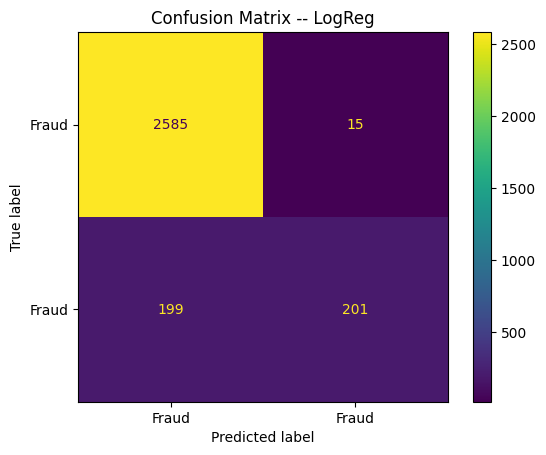

In [166]:
report_LR2 = classification_report(y_test_LR2, pred_LR2)
print(report_LR2)

# Confusion Matrix for LogReg
ConfusionMatrixDisplay.from_predictions(y_test_LR2, pred_LR2, display_labels=['Fraud', 'Fraud'])
plt.title('Confusion Matrix -- LogReg')
plt.show()